In [1]:
%pip install torchfile

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import h5py
from PIL import Image
import torchfile
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class EmbeddingImageDataset(Dataset):
    def __init__(self, image_path, embeddings_path, class_range=None, max_classes=20, transform=None):
        """
        Args:
            image_path (str): Path to folder containing image files (e.g. .jpg).
            embeddings_path (str): Path to folder containing class subdirectories.
                                    Each subdirectory should contain embedding files (.h5).
            class_range (iterable of ints, optional): Which class indices to load.
                                                      For example, range(20) loads classes 0-19.
                                                      If not provided, uses first max_classes.
            max_classes (int): Number of class folders to load if class_range is None.
            transform (callable, optional): Transform to apply to each image.
        """
        self.image_path = image_path
        self.embeddings_path = embeddings_path
        self.transform = transform if transform is not None else T.ToTensor()
        
        # Build a flattened list of samples: each sample is (class_index, embedding, image)
        self.samples = []
        
        # List only subdirectories in embeddings_path (e.g. "class_00001", "class_00002", etc.)
        all_class_dirs = sorted([d for d in os.listdir(embeddings_path)])
        
        if class_range is not None:
            selected_indices = list(class_range)
            selected_classes = [all_class_dirs[i] for i in selected_indices if i < len(all_class_dirs)]
        else:
            selected_classes = all_class_dirs[:max_classes]
            selected_indices = list(range(len(selected_classes)))
        
        for idx, class_dir in zip(selected_indices, selected_classes):
            class_folder = os.path.join(embeddings_path, class_dir)
            files = sorted([f for f in os.listdir(class_folder) if f.lower().endswith('.h5')])
            for file in files:
                base_name = os.path.splitext(file)[0]
                
                emb_file_path = os.path.join(class_folder, file)
                # Load embedding from .h5: if "embeddings" key exists, use it; otherwise, load all keys.
                with h5py.File(emb_file_path, "r") as hf:
                    keys = sorted(hf.keys())
                    emb_list = []
                    for key in keys:
                        emb_list.append(hf[key][()])
                    # We now have a list of arrays. They may have variable lengths.
                    # Convert each to a torch tensor.
                    emb_tensors = [torch.tensor(arr) for arr in emb_list]
                    # Instead of stacking here (which might fail), we keep them in a list.
                    # We will pad and stack them in the collate function.
                    emb = emb_tensors  # emb is now a list of tensors
                # If emb was loaded from "embeddings", ensure it has 2 dimensions (num_caps, embedding_dim)
                if not isinstance(emb, list):
                    if emb.ndim == 1:
                        # If it's a single vector, wrap it in a list.
                        emb = [torch.tensor(emb)]
                    else:
                        emb = torch.tensor(emb)
                        # Assume emb is (num_caps, embedding_dim); we'll keep it as tensor.
                
                # Load corresponding image from image_path with name base_name + ".jpg"
                img_file_path = os.path.join(image_path, base_name + ".jpg")
                if not os.path.exists(img_file_path):
                    print(f"Warning: Image file {img_file_path} not found; skipping {base_name}.")
                    continue
                img = Image.open(img_file_path).convert("RGB")
                img_tensor = self.transform(img)
                
                # Save sample as tuple: (class_index, embedding, image)
                self.samples.append((idx, emb, img_tensor))
                
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        # Returns a tuple: (class_index, embedding, image)
        # Note: embedding can be either a tensor or a list of tensors.
        return self.samples[idx]

def custom_collate(batch):
    """
    Each sample in batch is a tuple: (class_index, embedding, image)
    where embedding is a list of caption embeddings (each a 1D tensor of variable length).
    This collate function pads each embedding list so that:
      - All samples have the same number of captions (max_caps)
      - All caption vectors have the same length (max_dim)
    It returns a dictionary with:
      "class_index": tensor of class indices (B,)
      "embedding": tensor of shape (B, max_caps, max_dim)
      "image": tensor of shape (B, C, H, W)
    """
    import torch

    # Gather class indices and images (images are assumed to be of equal shape)
    class_indices = [item[0] for item in batch]
    images = torch.stack([item[2] for item in batch])
    
    # Determine max number of captions among samples (max_caps)
    max_caps = max(len(item[1]) for item in batch)
    # Determine max embedding dimension (max_dim) across all captions in the batch
    max_dim = 0
    for _, emb, _ in batch:
        for t in emb:
            if t.size(0) > max_dim:
                max_dim = t.size(0)
    
    padded_embeddings = []
    for _, emb, _ in batch:
        padded_caps = []
        # Pad each caption embedding in this sample to max_dim
        for t in emb:
            current_dim = t.size(0)
            if current_dim < max_dim:
                pad = torch.zeros(max_dim - current_dim, dtype=t.dtype)
                padded_t = torch.cat([t, pad], dim=0)
            else:
                padded_t = t
            padded_caps.append(padded_t)
        # If the number of captions is less than max_caps, pad with rows of zeros.
        num_caps = len(padded_caps)
        if num_caps < max_caps:
            pad_row = torch.zeros(max_dim, dtype=padded_caps[0].dtype)
            for _ in range(max_caps - num_caps):
                padded_caps.append(pad_row.clone())
        # Stack to get tensor of shape (max_caps, max_dim)
        sample_emb = torch.stack(padded_caps, dim=0)
        padded_embeddings.append(sample_emb)
    
    # Stack all sample embeddings: shape (B, max_caps, max_dim)
    embeddings = torch.stack(padded_embeddings, dim=0)
    class_indices = torch.tensor(class_indices)
    
    return {"class_index": class_indices, "embedding": embeddings, "image": images}

In [4]:
image_path = "jpg"
embeddings_path = "text_c10"

train_dataset = EmbeddingImageDataset(
    image_path=image_path,
    embeddings_path=embeddings_path,
    class_range=range(20),
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((64,64)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
)

test_dataset = EmbeddingImageDataset(
    image_path=image_path,
    embeddings_path=embeddings_path,
    class_range=range(20,25),
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((64,64)),
        torchvision.transforms.ToTensor()
    ])
)

In [5]:
sample = train_dataset[0]
class_index, embedding, image = sample

print("Class index:", class_index)
print("Embedding:", embedding[2].shape)
print("Image shape:", image.shape)


Class index: 0
Embedding: torch.Size([75])
Image shape: torch.Size([3, 64, 64])


In [6]:
class SourceEncoder(torch.nn.Module):
    def __init__(self):
        super(SourceEncoder, self).__init__()
        self.conv = torch.nn.Sequential(
            # 64x64 -> 32x32
            torch.nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 32x32 -> 16x16
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 16x16 -> 8x8
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 8x8 -> 4x4
            torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )
        
    def forward(self, x):
        # Returns feature map of shape (B, 512, 4, 4)
        return self.conv(x)

In [7]:
class TargetGenerator(torch.nn.Module):
    def __init__(self, source_dim=128, text_dim=306, ngf=64, output_channels=3):
        super(TargetGenerator, self).__init__()
        # fc_text now expects a 306-d input and outputs 256*4*4 = 4096 elements.
        self.fc_text = torch.nn.Linear(text_dim, 256 * 4 * 4)
        
        # After concatenation: source (B,512,4,4) + text (B,256,4,4) -> (B,768,4,4)
        self.reduce_conv = torch.nn.Sequential(
            torch.nn.Conv2d(768, 512, kernel_size=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Upsample from (B,512,4,4) to (B, output_channels, 64,64)
        self.deconv = torch.nn.Sequential(
            # 4x4 -> 8x8: 512 -> ngf*4 (256 channels if ngf=64)
            torch.nn.ConvTranspose2d(512, ngf * 4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 8x8 -> 16x16: ngf*4 -> ngf*2 (128 channels)
            torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 16x16 -> 32x32: ngf*2 -> ngf (64 channels)
            torch.nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 32x32 -> 64x64: ngf -> output_channels
            torch.nn.ConvTranspose2d(ngf, output_channels, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()  # outputs in [-1,1]
        )
        
    def forward(self, src_rep, text_enc):
        B = text_enc.size(0)
        # If text_enc has three dimensions (B, num_caps, 306), average them.
        if text_enc.dim() == 3:
            text_enc = text_enc.mean(dim=1)  # Now shape becomes (B,306)
        # Now, ensure the text encoding is exactly 306-dimensional:
        if text_enc.size(1) > 306:
            text_enc = text_enc[:, :306]
        elif text_enc.size(1) < 306:
            pad = torch.zeros(B, 306 - text_enc.size(1), device=text_enc.device, dtype=text_enc.dtype)
            text_enc = torch.cat([text_enc, pad], dim=1)
        text_enc = text_enc.float()
        
        # Project the 306-d text encoding to 4096 elements (256*4*4)
        text_proj = self.fc_text(text_enc)  # Expected shape: (B,4096)
        try:
            text_feat = text_proj.view(B, 256, 4, 4)  # Reshape to (B,256,4,4)
        except Exception as e:
            print("Error reshaping text_proj with shape", text_proj.shape)
            raise e
        
        # src_rep is expected to be (B,512,4,4)
        x = torch.cat([src_rep, text_feat], dim=1)  # (B,768,4,4)
        x = self.reduce_conv(x)                      # (B,512,4,4)
        img = self.deconv(x)                         # (B, output_channels, 64,64)
        return img

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_channels=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            # 64x64 -> 32x32
            torch.nn.Conv2d(input_channels, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 32x32 -> 16x16
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 16x16 -> 8x8
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # 8x8 -> 4x4
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # Final: 4x4 -> 1x1
            torch.nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, padding=0),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.main(x)
        return out.view(-1)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_encoder = SourceEncoder().to(device)
generator = TargetGenerator(text_dim=306, ngf=64, output_channels=3).to(device)
discriminator = Discriminator(input_channels=3, ndf=64).to(device)

c:\Users\critz\miniconda3\envs\venv\lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

source_encoder.apply(weights_init)
generator.apply(weights_init)
discriminator.apply(weights_init)

num_epochs = 50
batch_size = 16
learning_rate = 5e-4

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=custom_collate)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=custom_collate)

In [11]:
def denormalize(tensor):
    return (tensor + 1) / 2

def show_images(real_imgs, fake_imgs, real_scores, fake_scores, epoch, step, n=4):
    # Ensure we don't go out of bounds
    n = min(n, real_imgs.size(0), fake_imgs.size(0))
    
    real_imgs = real_imgs[:n].detach().cpu()
    fake_imgs = fake_imgs[:n].detach().cpu()
    real_imgs = denormalize(real_imgs).clamp(0,1)
    fake_imgs = denormalize(fake_imgs).clamp(0,1)

    real_scores = real_scores[:n].detach().cpu().numpy()
    fake_scores = fake_scores[:n].detach().cpu().numpy()

    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    fig.suptitle(f"Epoch {epoch+1}, Step {step}")
    for j in range(n):
        axes[0, j].imshow(np.transpose(real_imgs[j].numpy(), (1,2,0)))
        axes[0, j].axis("off")
        axes[0, j].set_title(f"Real D={real_scores[j]:.2f}")

        axes[1, j].imshow(np.transpose(fake_imgs[j].numpy(), (1,2,0)))
        axes[1, j].axis("off")
        axes[1, j].set_title(f"Fake D={fake_scores[j]:.2f}")
    plt.tight_layout()
    plt.show()


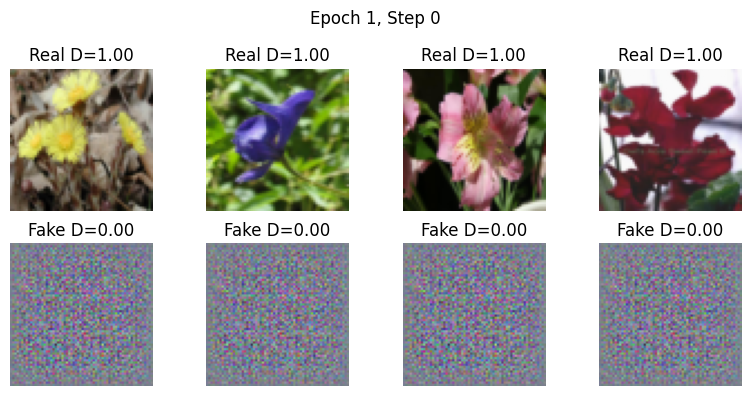

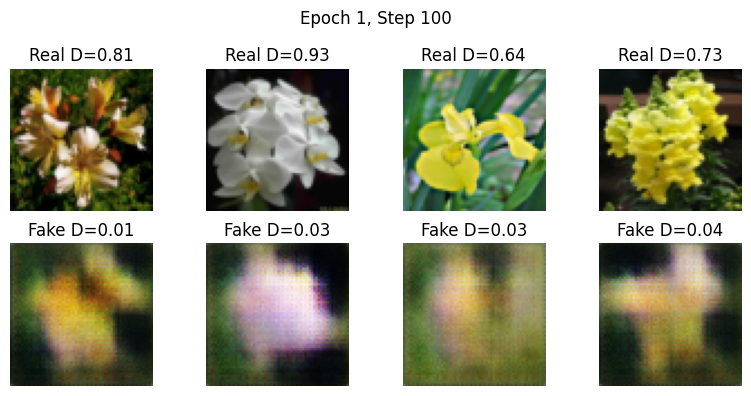

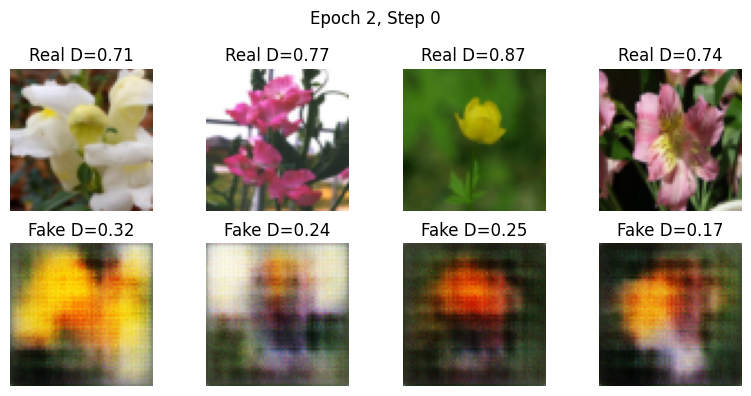

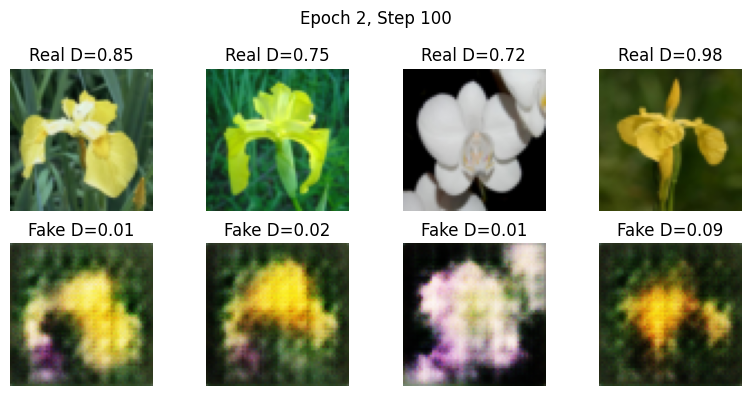

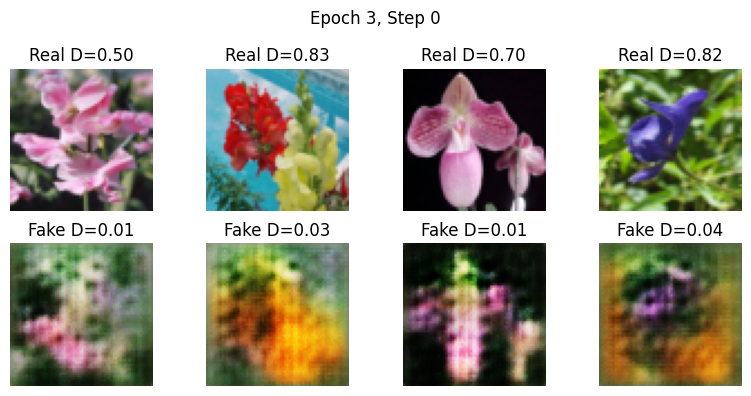

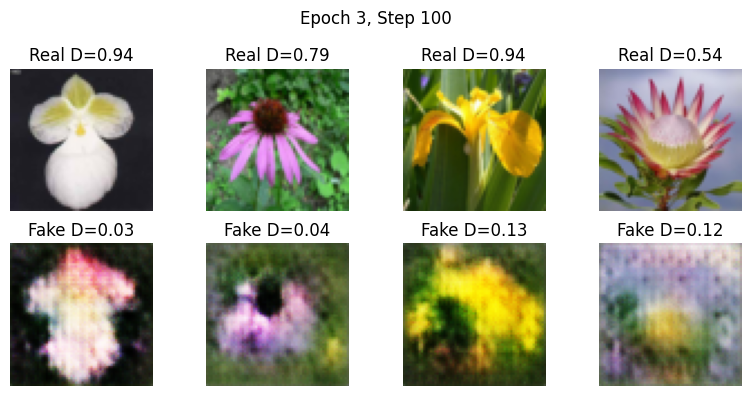

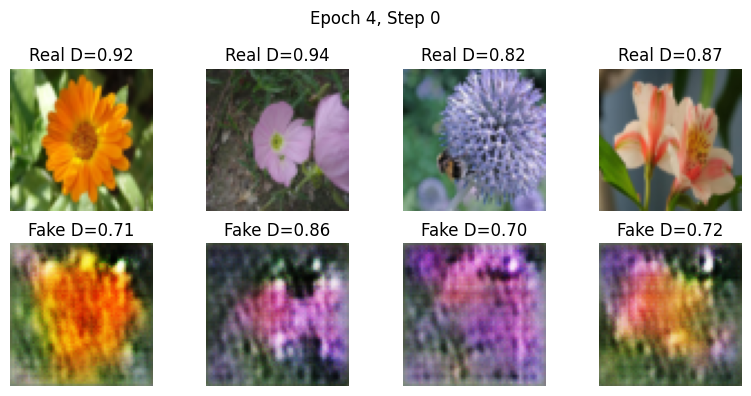

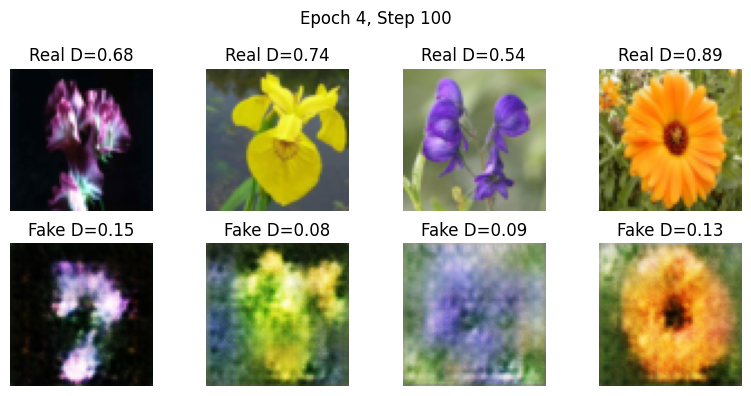

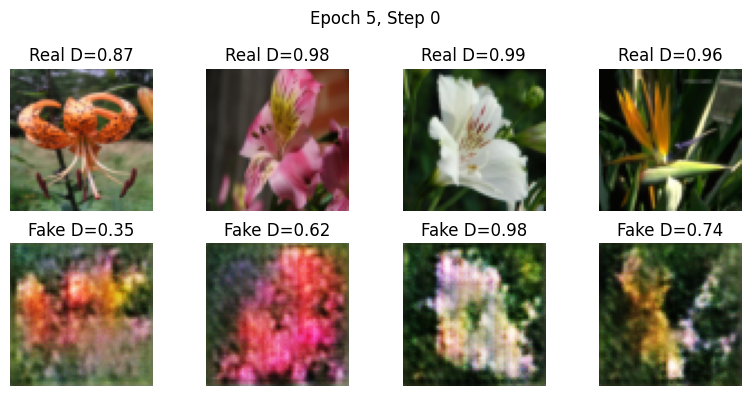

KeyboardInterrupt: 

In [12]:
criterion = torch.nn.BCELoss()
l1_loss = torch.nn.L1Loss()

optD = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optG = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optSE = torch.optim.Adam(source_encoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):
        real_imgs = batch["image"].to(device)
        text_enc = batch["embedding"].to(device)
        B = real_imgs.size(0)
        
        if text_enc.size(-1) < 306:
            pad = torch.zeros(text_enc.size(0), text_enc.size(1), 306 - text_enc.size(-1), device=device)
            text_enc = torch.cat([text_enc, pad], dim=-1)
        
        # 1. Train Discriminator
        discriminator.zero_grad()
        label_real = torch.ones(B, device=device)
        label_fake = torch.zeros(B, device=device)
        
        # Discriminator on real images
        output_real = discriminator(real_imgs)           # (B,)
        loss_real = criterion(output_real, label_real)
        
        # Generate fake images:
        src_rep = source_encoder(real_imgs)              # (B, 512, 4, 4)
        fake_imgs = generator(src_rep, text_enc)           # (B, 3, 64, 64)
        output_fake = discriminator(fake_imgs.detach())  
        loss_fake = criterion(output_fake, label_fake)
        
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optD.step()
        
        # 2. Train Generator + Source Encoder
        generator.zero_grad()
        source_encoder.zero_grad()
        
        src_rep = source_encoder(real_imgs)
        fake_imgs = generator(src_rep, text_enc)
        output_fake_for_G = discriminator(fake_imgs)
        loss_G_adv = criterion(output_fake_for_G, label_real)
        loss_G_L1 = l1_loss(fake_imgs, real_imgs)
        loss_G = loss_G_adv + 100 * loss_G_L1
        
        loss_G.backward()
        optG.step()
        optSE.step()
        
        with torch.no_grad():
            real_scores = discriminator(real_imgs)
            fake_scores = discriminator(fake_imgs)
        
        if i % 100 == 0:
            with torch.no_grad():
                real_scores = discriminator(real_imgs)
                fake_scores = discriminator(fake_imgs)
            show_images(real_imgs, fake_imgs, real_scores, fake_scores, epoch, i, n=4)
    
    if (epoch+1) % 10 == 0:
        torch.save({
            'epoch': epoch+1,
            'source_encoder': source_encoder.state_dict(),
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict()
        }, f"checkpoint_epoch_{epoch+1}.pth")

print("Training finished")

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

def show_images_with_scores(real_imgs, fake_imgs, real_scores, fake_scores, title=""):
    """
    Displays real images in one row and fake images in the next row,
    with each image labeled with its discriminator score.
    real_imgs, fake_imgs: list of numpy arrays of shape (C,H,W)
    real_scores, fake_scores: list of floats (discriminator outputs)
    """
    n = len(real_imgs)
    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    fig.suptitle(title)
    for j in range(n):
        axes[0, j].imshow(np.transpose(real_imgs[j], (1,2,0)))
        axes[0, j].axis("off")
        axes[0, j].set_title(f"Real D={real_scores[j]:.2f}")
        
        axes[1, j].imshow(np.transpose(fake_imgs[j], (1,2,0)))
        axes[1, j].axis("off")
        axes[1, j].set_title(f"Fake D={fake_scores[j]:.2f}")
    plt.tight_layout()
    plt.show()

def generate_test_grid(test_dataset, source_encoder, generator, discriminator):
    """
    For each test class, randomly selects 5 samples and computes:
      - the real image and its discriminator score,
      - the generated (fake) image (using source_encoder and generator) and its discriminator score.
    Displays the results in a grid per class.
    
    Assumes each sample from test_dataset is a tuple: (class_id, embedding, image)
    where:
      - class_id: integer label
      - embedding: either a tensor of shape (306,) or a list of tensors (variable lengths) that will be padded and averaged
      - image: a tensor of shape (3,H,W) (normalized to [-1,1])
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    source_encoder.eval()
    generator.eval()
    discriminator.eval()
    
    # Group samples by class.
    class_dict = {}
    for i in range(len(test_dataset)):
        sample = test_dataset[i]
        # Unpack: (class_id, embedding, image)
        class_id, embedding, image = sample
        if class_id not in class_dict:
            class_dict[class_id] = []
        class_dict[class_id].append(sample)
    
    # For each class, process 5 random samples.
    for class_id in sorted(class_dict.keys()):
        samples = class_dict[class_id]
        num_to_pick = min(5, len(samples))
        chosen_samples = random.sample(samples, num_to_pick)
        real_imgs_list = []
        fake_imgs_list = []
        real_scores_list = []
        fake_scores_list = []
        for s in chosen_samples:
            c_id, embedding, image = s
            # Process embedding: if it's a list, pad and average.
            if isinstance(embedding, list):
                # Determine maximum length among caption embeddings.
                max_len = max(e.shape[0] for e in embedding)
                padded_embeddings = [F.pad(e, (0, max_len - e.shape[0])) for e in embedding]
                embedding = torch.stack(padded_embeddings, dim=0).mean(dim=0)
            # Ensure embedding is of shape (306,). If not, truncate or pad.
            if embedding.shape[0] > 306:
                embedding = embedding[:306]
            elif embedding.shape[0] < 306:
                pad = torch.zeros(306 - embedding.shape[0], dtype=embedding.dtype)
                embedding = torch.cat([embedding, pad], dim=0)
            # Unsqueeze to add batch dimension.
            text_enc = embedding.unsqueeze(0).to(device)  # (1,306)
            real_img = image.unsqueeze(0).to(device)      # (1,3,H,W)
            
            with torch.no_grad():
                src_rep = source_encoder(real_img)  # (1,512,4,4)
                fake_img = generator(src_rep, text_enc)  # (1,3,64,64)
                # Compute discriminator scores.
                real_score = discriminator(real_img)
                fake_score = discriminator(fake_img)
            
            # Convert images to numpy arrays (denormalize if needed)
            real_imgs_list.append(real_img.squeeze(0).cpu().numpy())
            fake_imgs_list.append(fake_img.squeeze(0).cpu().numpy())
            real_scores_list.append(real_score.item())
            fake_scores_list.append(fake_score.item())
        
        # Display the grid for this class.
        show_images_with_scores(real_imgs_list, fake_imgs_list,
                                real_scores_list, fake_scores_list,
                                title=f"Test Class {class_id} (5 samples)")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6599735..0.9878222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6760577..0.97613925].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42096853..0.9400098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62687904..0.92161787].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6876143..0.944167].


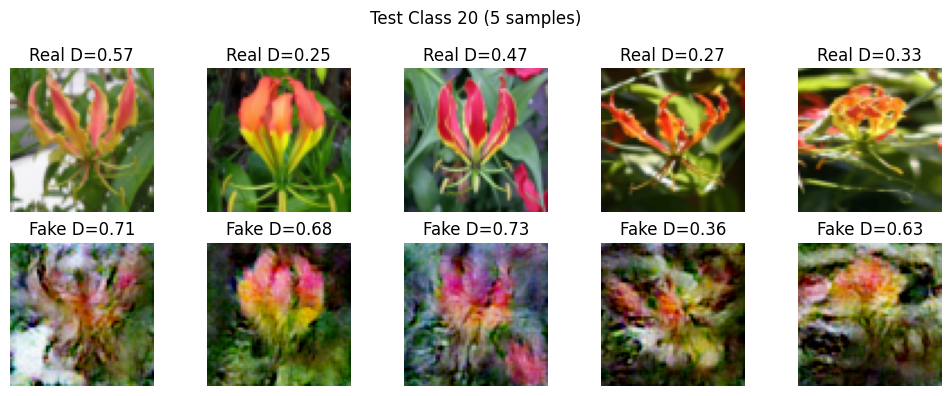

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78285503..0.99181205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23708214..0.99139494].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71986914..0.98353505].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2915266..0.99619424].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6548426..0.98306066].


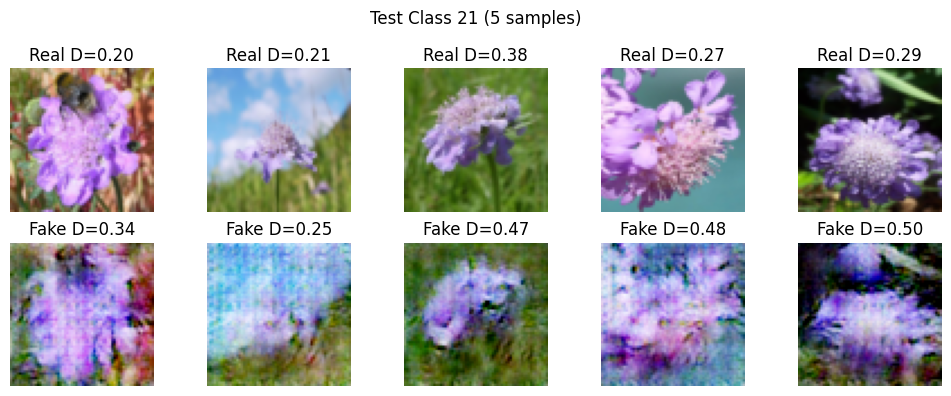

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44563..0.975966].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59528077..0.88748616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7228812..0.97529495].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3003602..0.81364644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26348582..0.7352402].


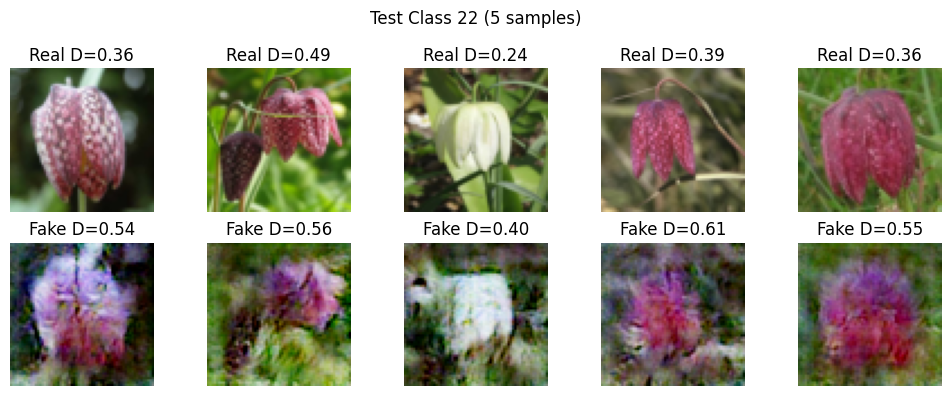

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35634205..0.63697517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59144473..0.9107825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48185173..0.946815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41275418..0.7683978].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48100835..0.9304616].


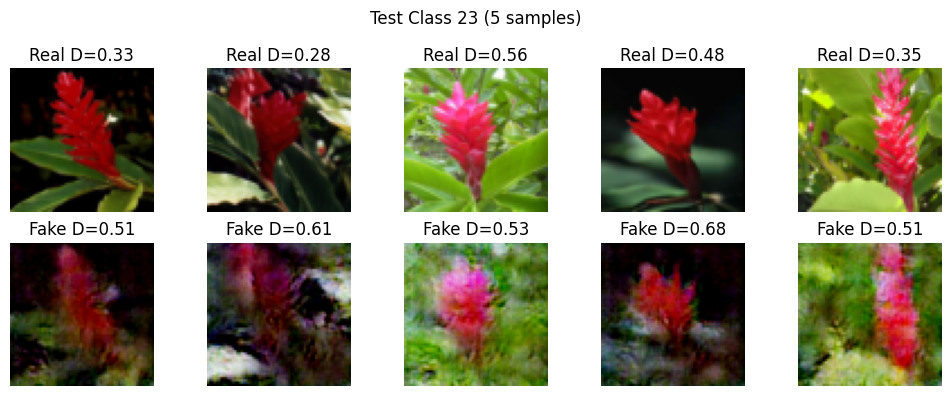

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3471536..0.978458].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7279705..0.96533865].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5462203..0.93698406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58341765..0.97901905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38550818..0.96323156].


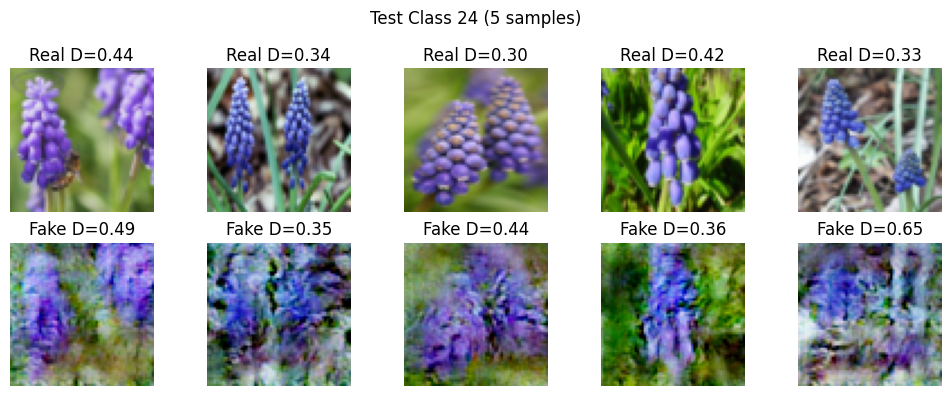

In [ ]:
generate_test_grid(test_dataset, source_encoder, generator, discriminator)

c:\Users\critz\miniconda3\envs\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\critz\miniconda3\envs\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\critz\miniconda3\envs\venv\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\critz\miniconda3\envs\venv\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\critz\miniconda3\envs\venv\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executabl

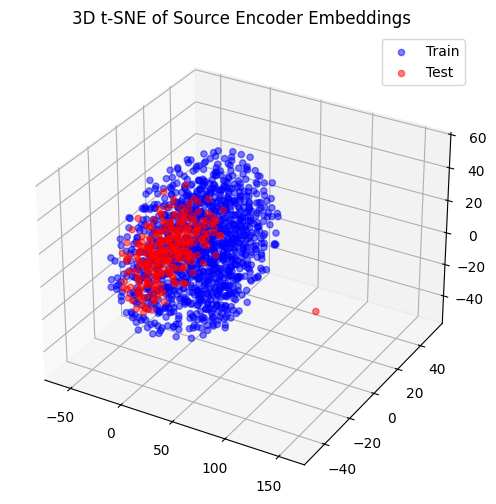

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def compute_source_embeddings(dataset, source_encoder):
    """
    dataset: yields samples as a tuple (class_id, embedding, image).
    Returns a list of (embedding, label) for each sample.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    source_encoder.eval()
    
    embeddings = []
    labels = []
    for i in range(len(dataset)):
        # Unpack the tuple
        class_id, emb, img = dataset[i]  # e.g. (int, Tensor, Tensor)
        
        # If needed, unsqueeze for batch dimension
        img = img.unsqueeze(0).to(device)  # shape: (1,3,H,W)
        
        with torch.no_grad():
            src_rep = source_encoder(img)  # e.g. (1,512,4,4)
            # Flatten or average if needed. Suppose we flatten:
            src_rep_flat = src_rep.view(1, -1).cpu().numpy()  # shape: (1, some_dim)
        
        embeddings.append(src_rep_flat.squeeze(0))
        labels.append(class_id)
    
    return np.array(embeddings), np.array(labels)


def plot_3d_tsne(train_emb, train_labels, test_emb, test_labels):
    all_emb = np.concatenate([train_emb, test_emb], axis=0)
    all_labels = np.concatenate([train_labels, test_labels], axis=0)
    
    tsne = TSNE(n_components=3, perplexity=30, random_state=42)
    emb_3d = tsne.fit_transform(all_emb)  # shape (N,3)
    
    # Split back
    N_train = train_emb.shape[0]
    emb_3d_train = emb_3d[:N_train]
    emb_3d_test = emb_3d[N_train:]
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(projection='3d')
    # Plot train embeddings in one color
    ax.scatter(emb_3d_train[:,0], emb_3d_train[:,1], emb_3d_train[:,2], c='blue', label='Train', alpha=0.5)
    # Plot test embeddings in another color
    ax.scatter(emb_3d_test[:,0], emb_3d_test[:,1], emb_3d_test[:,2], c='red', label='Test', alpha=0.5)
    
    ax.set_title("3D t-SNE of Source Encoder Embeddings")
    ax.legend()
    plt.show()

# Example usage
train_emb, train_labels = compute_source_embeddings(train_dataset, source_encoder)
test_emb, test_labels = compute_source_embeddings(test_dataset, source_encoder)
plot_3d_tsne(train_emb, train_labels, test_emb, test_labels)

In [ ]:
def print_model_stats(model, model_name="Model"):
    # total parameters
    total_params = sum(p.numel() for p in model.parameters())
    # trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Save temporary checkpoint to get size on disk
    tmp_path = f"tmp_{model_name}.pth"
    torch.save(model.state_dict(), tmp_path)
    import os
    size_on_disk = os.path.getsize(tmp_path) / 1e6  # MB
    os.remove(tmp_path)
    
    print(f"{model_name} Stats:")
    print(f"  Total Params:      {total_params}")
    print(f"  Trainable Params:  {trainable_params}")
    print(f"  Model Size on Disk: {size_on_disk:.2f} MB")

# Example usage
print_model_stats(source_encoder, "SourceEncoder")
print_model_stats(generator, "Generator")
print_model_stats(discriminator, "Discriminator")

SourceEncoder Stats:
  Total Params:      2758464
  Trainable Params:  2758464
  Model Size on Disk: 11.05 MB
Generator Stats:
  Total Params:      4409155
  Trainable Params:  4409155
  Model Size on Disk: 17.66 MB
Discriminator Stats:
  Total Params:      2766529
  Trainable Params:  2766529
  Model Size on Disk: 11.08 MB
